# Logistic Regression 
**Here we show one example of Logistic Regression using scikit-learn library. How to tune Hyperparameters using Grid and Random Search and Cross validation with several folds**

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE

from scipy.stats import expon

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# Helper Functions

In [5]:
def pie_plot(series, figsize=(7,7)):
    plt.figure(figsize=figsize)
    val_counts = series.value_counts()
    val_sum = val_counts.sum()
    plt.pie(val_counts, labels=val_counts.index,autopct=lambda p: '{:.1f}% ({:,})'.format(p,int(p*val_sum/100)));

In [6]:
def get_confusion_matrix(y_test, y_pred):
    return pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['True', 'False'], index=['Pred_True', 'Pred_False'])

In [7]:
def plot_roc_auc_curve(y_test, y_pred, clf, X_test):
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    plt.figure(figsize=[10,7])
    plt.plot(fpr, tpr,label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.plot(fpr, thresholds,'g:',label='Thresholds')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="upper right")
    plt.savefig('Log_ROC')
    plt.show()


# The Data

 The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe (1/0) a term deposit (variable y).

 This dataset provides the customer information. It includes over 41K records and 21 fields.


## Read Data

In [5]:
data = pd.read_csv('../data/ml_intro/banking.csv', header=0)

In [6]:
data.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1
5,30,management,divorced,basic.4y,no,yes,no,cellular,jul,tue,...,8,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,0
6,37,blue-collar,married,basic.4y,no,yes,no,cellular,may,thu,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.327,5099.1,0
7,39,blue-collar,divorced,basic.9y,no,yes,no,cellular,may,fri,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
8,36,admin.,married,university.degree,no,no,no,cellular,jun,mon,...,1,3,1,success,-2.9,92.963,-40.8,1.266,5076.2,1
9,27,blue-collar,single,basic.4y,no,yes,no,cellular,apr,thu,...,2,999,1,failure,-1.8,93.075,-47.1,1.410,5099.1,0


# Take only target and Numerical Features for Simplicity

## Numerical variable descriptions

- age (numeric)

- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

- previous: number of contacts performed before this campaign and for this client (numeric)

- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

- emp.var.rate: employment variation rate - (numeric)

- cons.price.idx: consumer price index - (numeric)

- cons.conf.idx: consumer confidence index - (numeric)

- euribor3m: euribor 3 month rate - (numeric)

- nr.employed: number of employees - (numeric)

In [7]:
numerical_features = ['age', 'campaign', 'pdays', 'duration', 'previous', 
                      'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

## Numerical variable distributions

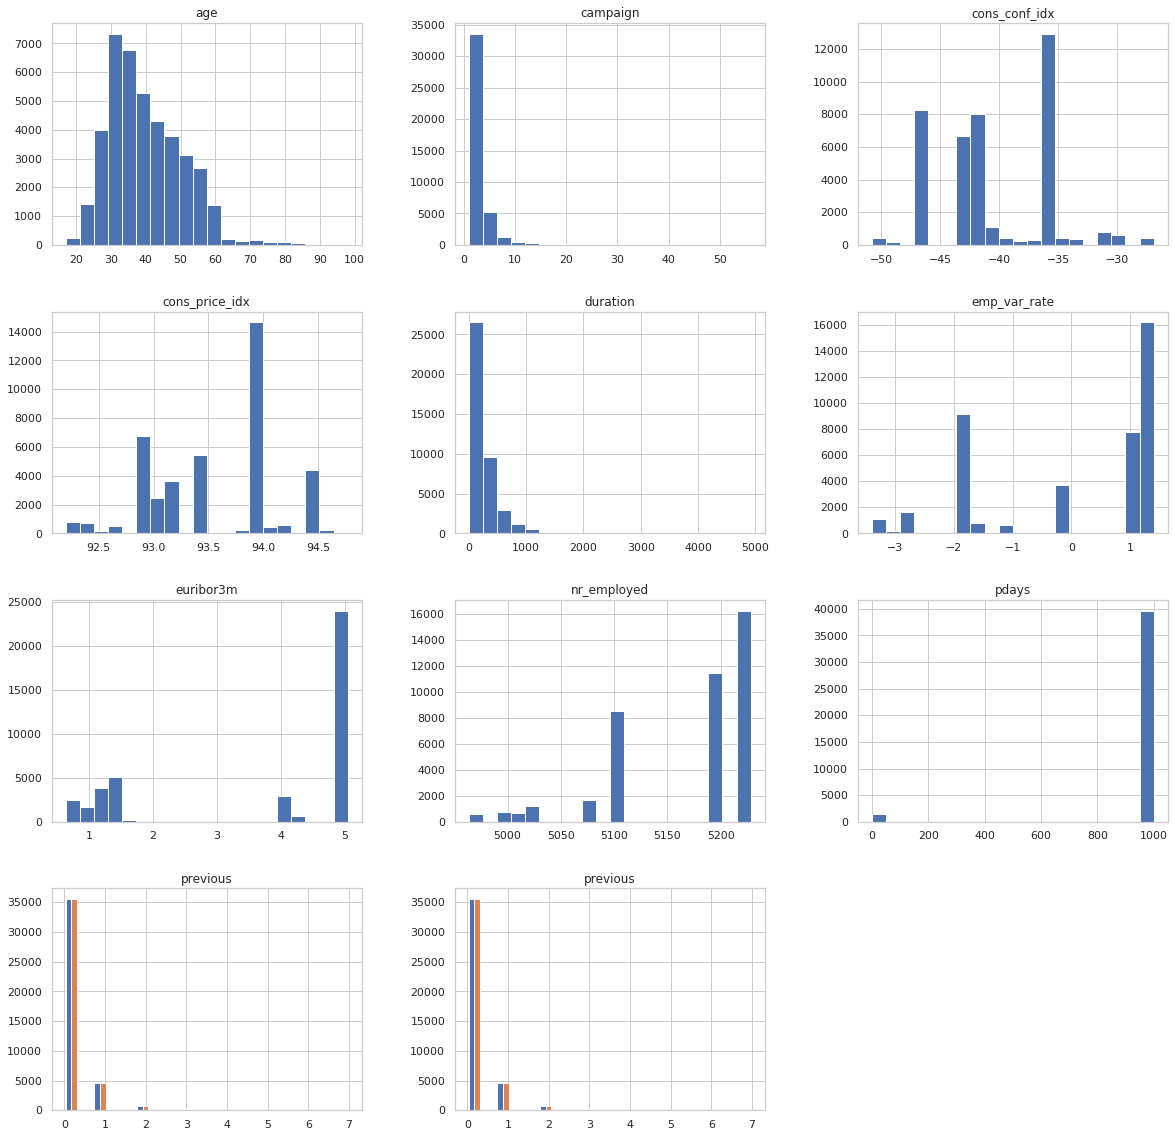

In [8]:
data[numerical_features].hist(bins=20, figsize=(20,20));

## Target variable:

y - has the client subscribed a term deposit? (binary: '1','0')

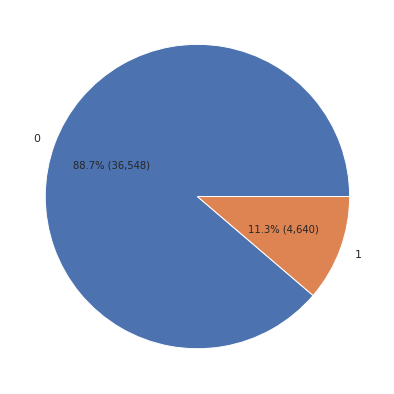

In [9]:
pie_plot(data.y)

## Take little part of the data to train models faster

In [10]:
data.sample(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
37069,30,technician,married,professional.course,no,no,yes,cellular,aug,wed,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,0
23058,49,blue-collar,married,basic.9y,unknown,yes,no,cellular,jul,thu,...,19,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0


In [11]:
data_sample = data.sample(10000)

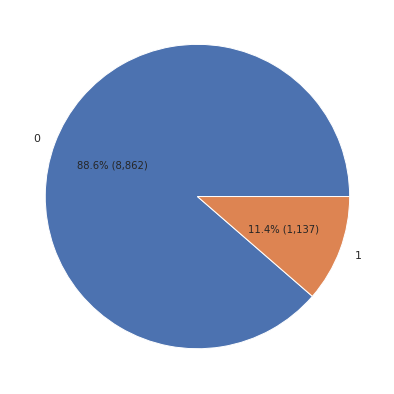

In [12]:
pie_plot(data_sample['y'])

## divide data into features and target

In [13]:
X = data_sample[numerical_features]
y = data_sample['y']

In [14]:
X.shape, y.shape

((10000, 11), (10000,))

# Oversample the minority class by synthetically generating additional samples

In [15]:
os = SMOTE(random_state=0, sampling_strategy=1)
X, y = os.fit_resample(X, y)

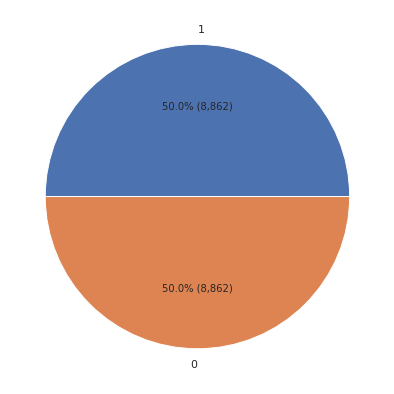

In [16]:
pie_plot(pd.Series(y))

In [17]:
X.shape

(17724, 11)

# Logistic Regression Model Fitting

## Split data into train and test sets

Here we won't see effect of stratify because we have balanced target. The use of stratify is to have the same distribution of target in train and test splits

In [18]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12406, 11), (5318, 11), (12406,), (5318,))

## Create Logistic Regression classifier

In [21]:
clf = LogisticRegression()

In [22]:
clf.tol = 0.01
clf.max_iter = 150

## Create Parameter Grids

### GridSearchCV

Here we are going to create several splits of training data (K-folds) and then we are going to run grid search on every split. 
We will check calculated scores distributions on each split.

In [23]:
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 150,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.01,
 'verbose': 0,
 'warm_start': False}

parameter grid defines several choises for each hyperparameter we need to tune

In [24]:
grid_parameters = {'penalty' : ['l1', 'l2'],
     'C' : np.logspace(-3, 1, 10),
     'solver' : ['liblinear'],
    }

In [25]:
with np.printoptions(precision=5,suppress=True):
    print(np.logspace(-3,1, 10))

[ 0.001    0.00278  0.00774  0.02154  0.05995  0.16681  0.46416  1.29155
  3.59381 10.     ]


In [26]:
np.logspace(-3,1, 10)

array([1.00000000e-03, 2.78255940e-03, 7.74263683e-03, 2.15443469e-02,
       5.99484250e-02, 1.66810054e-01, 4.64158883e-01, 1.29154967e+00,
       3.59381366e+00, 1.00000000e+01])

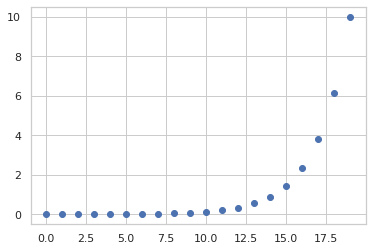

In [27]:
plt.scatter(x=range(20),y=np.logspace(-3, 1, 20))

###  RandomizedSearchCV

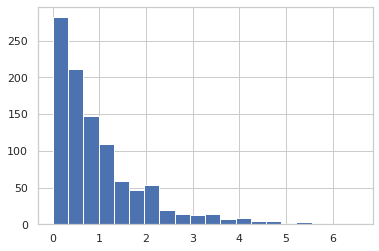

In [28]:
pd.Series(expon.rvs(size=1000)).hist(bins=20)

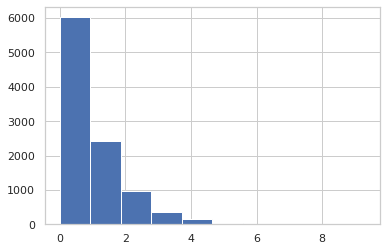

In [29]:
hist_arr, x_axis_arr, some_arr = plt.hist(expon.rvs(size=10000),bins=10)

In [30]:
hist_arr

array([6.026e+03, 2.416e+03, 9.720e+02, 3.470e+02, 1.530e+02, 4.900e+01,
       1.900e+01, 1.400e+01, 3.000e+00, 1.000e+00])

In [31]:
x_axis_arr

array([1.47124551e-04, 9.28920624e-01, 1.85769412e+00, 2.78646762e+00,
       3.71524112e+00, 4.64401462e+00, 5.57278812e+00, 6.50156162e+00,
       7.43033512e+00, 8.35910862e+00, 9.28788212e+00])

In [32]:
with np.printoptions(precision=3,suppress=True):
    print(expon.rvs(size=20).sort())

None


In [33]:
np.sort(expon.rvs(size=20),kind='mergesort')

array([0.01132448, 0.06953604, 0.08102146, 0.11258701, 0.16435331,
       0.19137105, 0.239093  , 0.24266345, 0.29973003, 0.41680297,
       0.67233764, 0.7383951 , 0.81864585, 1.02800677, 1.24947258,
       1.31701175, 1.56466825, 1.66770641, 1.9414543 , 2.10112012])

In [34]:
%precision

'%r'

In [35]:
expon.cdf(np.linspace(0,7,50))

array([0.        , 0.1331221 , 0.24852271, 0.34856094, 0.43528188,
       0.51045834, 0.57562715, 0.63212056, 0.68109344, 0.72354695,
       0.76034896, 0.79225181, 0.81990769, 0.84388195, 0.86466472,
       0.88268083, 0.89829861, 0.91183731, 0.92357371, 0.93374774,
       0.94256738, 0.95021293, 0.95684069, 0.96258615, 0.96756676,
       0.97188434, 0.97562716, 0.97887172, 0.98168436, 0.98412258,
       0.98623621, 0.98806848, 0.98965683, 0.99103373, 0.99222734,
       0.99326205, 0.99415902, 0.99493659, 0.99561064, 0.99619496,
       0.99670149, 0.9971406 , 0.99752125, 0.99785122, 0.99813727,
       0.99838524, 0.9986002 , 0.99878655, 0.99894808, 0.99908812])

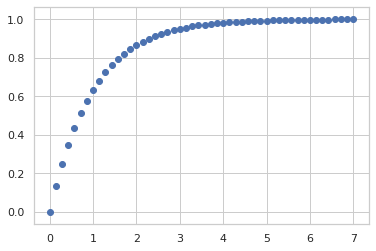

In [36]:
plt.scatter(np.linspace(0,7,50),expon.cdf(np.linspace(0,7,50)))

## Create grid search object

- cv: cross validation (number of splits to do in data for cross validation the same as K-fold)
- verbose: to show some logs while training
- n_jobs: uses parallel runs for training different models (-1 means "all")

There will be **CV*|PARAMS|** = **5x(20x2x1)** models trained (all combinations of parameters times number of splits)

In [37]:
grid_clf = GridSearchCV(estimator=clf, param_grid=grid_parameters, cv=5, verbose=True, n_jobs=-1)

### Randomized Grid search searches parameters not from predefined list of parameters but randomly generated parameters

There will be **CV*|iters|** = **5x20** models trained (n random combinations of parameters times number of splits)

In [38]:
random_parameters = {'penalty' : ['l1', 'l2'],
     'C' : expon.rvs(size=20),
     'solver' : ['liblinear'],
    }

In [39]:
random_clf = RandomizedSearchCV(estimator=clf,
                                   random_state=42, 
                                   param_distributions=random_parameters, 
                                   cv=5, 
                                   verbose=True,
                                   n_jobs=-1, 
                                   n_iter=20)

## Using RandomizedSearchCV

## Fit on data

In [40]:
best_param_grid_clf = grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    3.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished


In [41]:
best_param_random_clf = random_clf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    4.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.5s finished


## Check Score Distributions on splits

In [42]:
grid_clf.cv_results_

{'mean_fit_time': array([0.08823662, 0.07323489, 0.10621824, 0.08127894, 0.10299101,
        0.08492785, 0.0980504 , 0.08734636, 0.12034106, 0.09030814,
        0.20856671, 0.08166556, 0.11874833, 0.0871963 , 0.15353985,
        0.08411016, 0.13254185, 0.08550038, 0.15376077, 0.08174863]),
 'std_fit_time': array([0.05247345, 0.00722225, 0.02336464, 0.00603438, 0.01673287,
        0.00856357, 0.01886309, 0.01390745, 0.02574904, 0.01985342,
        0.01504974, 0.00998829, 0.03235075, 0.00589494, 0.04519799,
        0.01109841, 0.00814344, 0.00785716, 0.02704267, 0.00757146]),
 'mean_score_time': array([0.02145205, 0.00106568, 0.00115628, 0.0011889 , 0.00114884,
        0.00120716, 0.00117321, 0.00136251, 0.00110455, 0.00121255,
        0.00122447, 0.00110102, 0.0011549 , 0.0010551 , 0.00121789,
        0.00123706, 0.00113516, 0.00117002, 0.00108018, 0.00111265]),
 'std_score_time': array([1.19468037e-02, 1.24638557e-04, 1.52694799e-04, 1.34800321e-04,
        4.70864561e-05, 1.57224600e-

In [43]:
best_param_random_clf.cv_results_

{'mean_fit_time': array([0.07282624, 0.18524051, 0.08554125, 0.14948182, 0.14716988,
        0.17212982, 0.0839107 , 0.09016838, 0.09115787, 0.14676304,
        0.08740244, 0.08845091, 0.08708959, 0.08330364, 0.14346976,
        0.23385167, 0.09427495, 0.23287501, 0.20317702, 0.078935  ]),
 'std_fit_time': array([0.00857727, 0.02903458, 0.01135953, 0.03517716, 0.04790883,
        0.03756298, 0.01176686, 0.01596033, 0.01521819, 0.05212849,
        0.01434102, 0.01070005, 0.01215805, 0.01192421, 0.00972791,
        0.06721937, 0.02484457, 0.08831643, 0.07644638, 0.02343998]),
 'mean_score_time': array([0.02560077, 0.00117021, 0.00114994, 0.00114369, 0.00121737,
        0.00117111, 0.00112844, 0.00123315, 0.00114865, 0.00115314,
        0.00117803, 0.00130763, 0.00128484, 0.00129223, 0.00120649,
        0.00173159, 0.0012867 , 0.00136375, 0.00240126, 0.00095477]),
 'std_score_time': array([1.94262885e-02, 9.49259793e-05, 1.27138719e-04, 1.26117885e-04,
        6.74681612e-05, 6.15228969e-

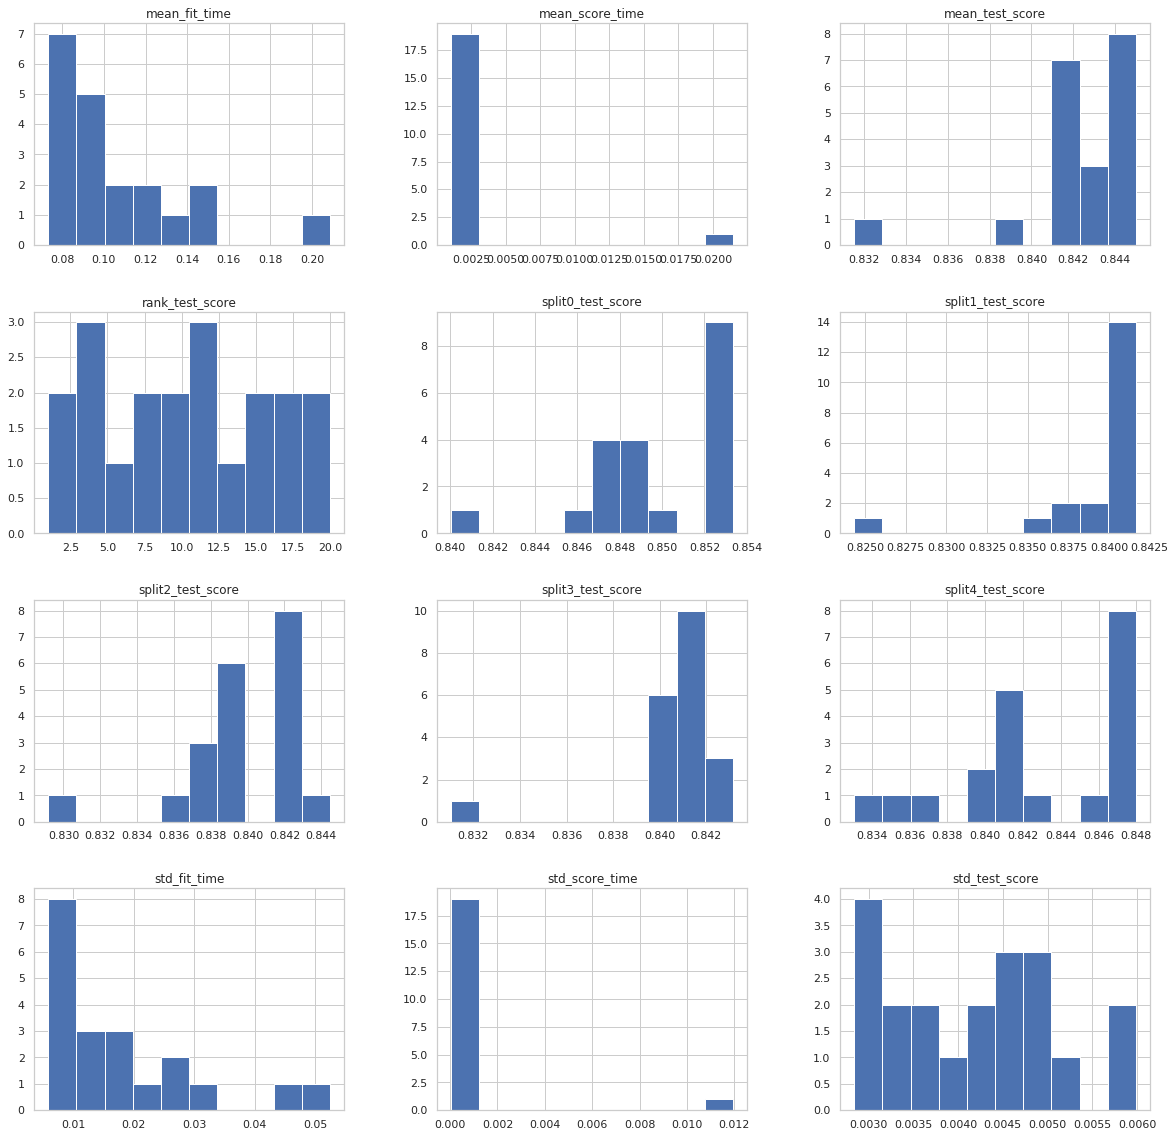

In [44]:
pd.DataFrame(grid_clf.cv_results_).hist(figsize=(20, 20));

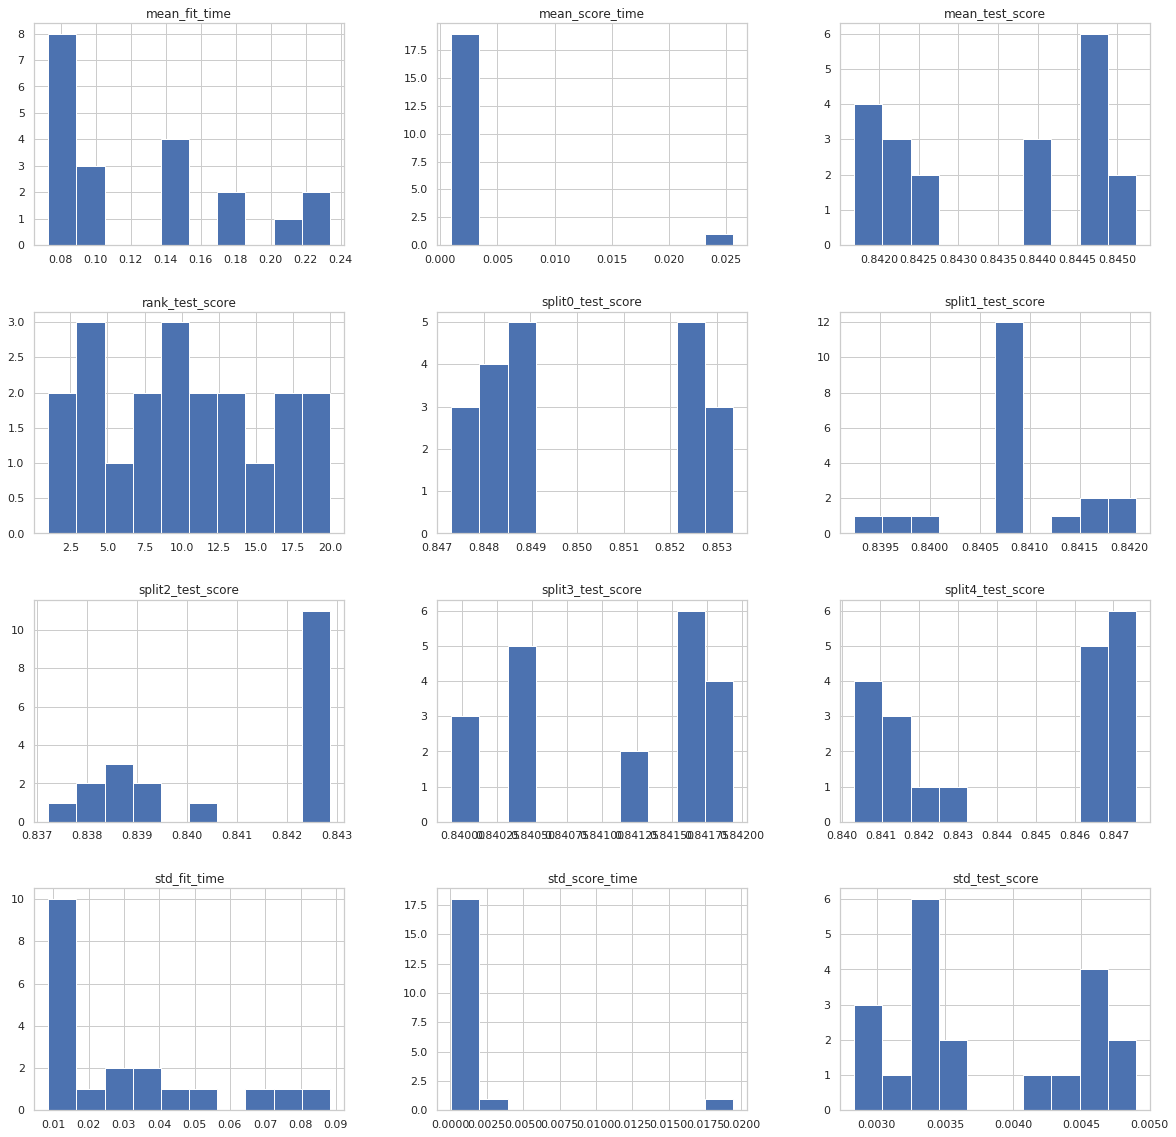

In [45]:
pd.DataFrame(random_clf.cv_results_).hist(figsize=(20, 20));

## Check Best parameter models

In [46]:
best_param_grid_clf.best_params_

{'C': 1.2915496650148828, 'penalty': 'l2', 'solver': 'liblinear'}

In [47]:
best_param_random_clf.best_params_

{'solver': 'liblinear', 'penalty': 'l2', 'C': 0.17786215518347562}

## Predict on test data using best model

In [48]:
y_pred_grid = best_param_grid_clf.predict(X_test)

In [49]:
y_pred_random = best_param_random_clf.predict(X_test)

## Confusion Matrices

In [138]:
get_confusion_matrix(y_test, y_pred_grid)

,True,False
Pred_True,2311,348
Pred_False,469,2190


In [154]:
get_confusion_matrix(y_test, y_pred_random)

,True,False
Pred_True,2311,348
Pred_False,469,2190


## classification reports

In [52]:
print(classification_report(y_test, y_pred_grid))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      2659
           1       0.86      0.82      0.84      2659

    accuracy                           0.85      5318
   macro avg       0.85      0.85      0.85      5318
weighted avg       0.85      0.85      0.85      5318



In [53]:
y_test[y_test==0].shape, y_test[y_test==1].shape

((2659,), (2659,))

In [54]:
print(classification_report(y_test, y_pred_random))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      2659
           1       0.86      0.82      0.84      2659

    accuracy                           0.85      5318
   macro avg       0.85      0.85      0.85      5318
weighted avg       0.85      0.85      0.85      5318



## ROC-AUC curves

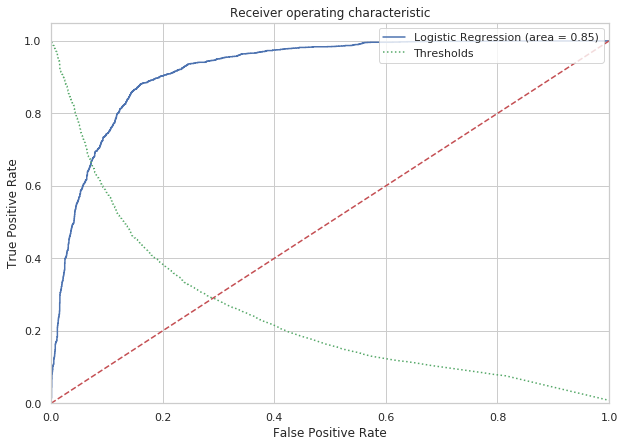

In [169]:
plot_roc_auc_curve(y_test, y_pred_grid, best_param_grid_clf, X_test)

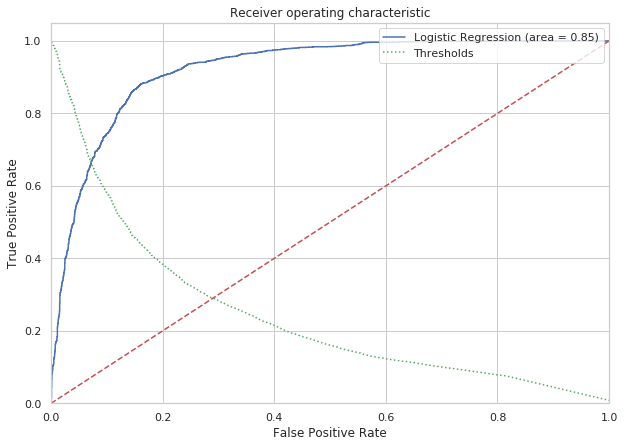

In [170]:
plot_roc_auc_curve(y_test, y_pred_random, best_param_random_clf, X_test)

In [172]:
tp, fp, fn, tn = confusion_matrix(y_test, y_pred_grid).ravel()

In [173]:
false_positive_rate = fp/(fp+tn)

In [174]:
true_positive_rate = tp/(tp+fn)

In [175]:
print('false_positive_rate = {:.4f}'.format(false_positive_rate))
print('true_positive_rate = {:.4f}'.format(true_positive_rate))

false_positive_rate = 0.1371
true_positive_rate = 0.8313


In [176]:
fpr, tpr, thresholds = roc_curve(y_test, best_param_grid_clf.predict_proba(X_test)[:,1])

In [177]:
roc_data = pd.DataFrame({'fpr':fpr,'tpr':tpr, 'thresholds':thresholds})

In [185]:
roc_data.loc[(roc_data['fpr']>0.1360) & (roc_data['fpr']<0.1387)]

,fpr,tpr,thresholds
573,0.136517,0.836029,0.488941
574,0.136517,0.837909,0.486795
575,0.136894,0.837909,0.486389
576,0.136894,0.839789,0.485368
577,0.138022,0.839789,0.484469
578,0.138022,0.840165,0.484404
